# 1) Resnet 구현

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block_34(inputs, filters, strides=1, downsample=False):
    identity = inputs
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        identity = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

def resnet_block_50(inputs, filters, strides=1, downsample=False):
    shortcut = inputs
    strides_temp = strides
    if downsample:
        if not filters == 64:
            strides_temp = 2
    
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters*4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_block(inputs, filters, strides=1, downsample=False, is_50=False):
    if is_50:
         x = resnet_block_50(inputs, filters, strides=strides, downsample=downsample)
    else:
         x = resnet_block_34(inputs, filters, strides=strides, downsample=downsample)
    return x

def build_resnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = resnet_block(x, filters, strides=strides, downsample=True, is_50=is_50)

        for _ in range(1, num_blocks):
            x = resnet_block(x, filters, is_50=is_50)

    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Resnet_50' if is_50 else 'Resnet_34'
    model = Model(inputs=inputs, outputs=x, name=name)

    model = Model(inputs=inputs, outputs=x)
    return model


# 2) ResNet-34, ResNet-50 Complete Model

In [2]:
#Build ResNet-34
input_shape = (32, 32, 3)
num_classes = 10

resnet_34 = build_resnet(input_shape, False, num_classes )
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
# Build ResNet-50
input_shape = (32, 32, 3)
num_classes = 10

resnet_50 = build_resnet(input_shape, True, num_classes )
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기

In [4]:
def plain_block_34(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block_50(inputs, filters, strides=1):
    strides_temp = 1
    if strides == 2:
        if not filters == 64:
            strides_temp = 2
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block(inputs, filters, strides=1, is_50=False):
    if is_50:
         x = plain_block_50(inputs, filters, strides=strides)
    else:
         x = plain_block_34(inputs, filters, strides=strides)
    return x

def build_plain(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = plain_block(x, filters, strides=strides, is_50=is_50)

        for _ in range(1, num_blocks):
            x = plain_block(x, filters, is_50=is_50)
    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Plain_50' if is_50 else 'Plain_34'
    model = Model(inputs=inputs, outputs=x, name=name)
    return model


In [5]:
#Build Plain-34
input_shape = (224, 224, 3)
num_classes = 10

plain_34 = build_plain(input_shape, False, num_classes, True)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256

In [6]:
#Build Plain-50
input_shape = (224, 224, 3)
num_classes = 10

plain_50 = build_plain(input_shape, True, num_classes, False )
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_139 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_140 (Bat (None, 56, 56, 64)        256

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### Ablation Study

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import urllib3
import tensorflow_datasets as tfds
try:
    # Load the tf_flowers dataset
    dataset_name = 'cats_vs_dogs'
    train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

    # Preprocess the images and create batches
    batch_size = 32
    def preprocess_image(image, label):
        image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
        image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet
        return image, label

    train_dataset = train_dataset.map(preprocess_image)
    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.map(preprocess_image)
    validation_dataset = validation_dataset.batch(batch_size)
except:
    print('이미지 다운로드 실패')
    pass
input_shape = (224, 224, 3)
num_classes = 2

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

이미지 다운로드 실패


이미지 다운로드 실패하여  [https://www.microsoft.com/en-us/download/details.aspx?id=54765] 사이트에서 다운받아 사용

In [9]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
# # 데이터 경로 설정
# train_dir = './data/PetImages/'

# # 데이터 전처리 및 증강
# image_size = (224, 224)  # 이미지 크기 설정
# batch_size = 32

# # 데이터 증강 설정
# datagen = ImageDataGenerator(
#     rescale=1./255,  # 이미지 스케일 조정
# )

# # 훈련 데이터셋 생성
# train_dataset = datagen.flow_from_directory(
#     train_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',  # 이진 분류인 경우
#     # class_mode='categorical'  # 다중 분류인 경우
#     shuffle=True
# )


# # 훈련 데이터셋과 검증 데이터셋으로 분할
# train_images, val_images, train_labels, val_labels = train_test_split(
#     train_dataset[0][0],
#     train_dataset[0][1],
#     test_size=0.2,
#     random_state=42
# )

# # 훈련 데이터셋 생성
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# train_dataset = train_dataset.batch(batch_size)

# # 검증 데이터셋 생성
# validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
# validation_dataset = validation_dataset.batch(batch_size)

# input_shape = (224, 224, 3)
# num_classes = 2
# epoch = 100

Found 25000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
train_dir = './data/PetImages/'

# 데이터 전처리 및 증강
image_size = (224, 224)  # 이미지 크기 설정
batch_size = 32

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 스케일 조정
    validation_split=0.2  # 검증 데이터셋 분할 비율 설정
)

# 훈련 데이터셋 및 검증 데이터셋 생성
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # 훈련 데이터셋 설정
    shuffle=True
)

validation_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # 검증 데이터셋 설정
    shuffle=True
)

input_shape = (224, 224, 3)
num_classes = 2
epochs = 100

In [10]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plain(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.7609 - accuracy: 0.5600 - val_loss: 3.7694 - val_accuracy: 0.5714
Epoch 2/100
1/1 [==============================] - 0s 192ms/step - loss: 6.3260 - accuracy: 0.4800 - val_loss: 0.7017 - val_accuracy: 0.4286
Epoch 3/100
1/1 [==============================] - 0s 188ms/step - loss: 1.0247 - accuracy: 0.6000 - val_loss: 0.7911 - val_accuracy: 0.2857
Epoch 4/100
1/1 [==============================] - 0s 184ms/step - loss: 2.8759 - accuracy: 0.6800 - val_loss: 10.4070 - val_accuracy: 0.5714
Epoch 5/100
1/1 [==============================] - 0s 185ms/step - loss: 3.4719 - accuracy: 0.4800 - val_loss: 98.8213 - val_accuracy: 0.5714
Epoch 6/100
1/1 [==============================] - 0s 182ms/step - loss: 0.7793 - accuracy: 0.7600 - val_loss: 554.4313 - val_accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 183ms/step - loss: 0.5673 - accuracy: 0.7200 - val_loss: 2213.8613 - val_accuracy: 0.5714
Epoch 8/1

Epoch 57/100
1/1 [==============================] - 0s 188ms/step - loss: 1.8563e-04 - accuracy: 1.0000 - val_loss: 219.5337 - val_accuracy: 0.5714
Epoch 58/100
1/1 [==============================] - 0s 189ms/step - loss: 1.7985e-04 - accuracy: 1.0000 - val_loss: 201.5654 - val_accuracy: 0.5714
Epoch 59/100
1/1 [==============================] - 0s 190ms/step - loss: 1.7449e-04 - accuracy: 1.0000 - val_loss: 185.4214 - val_accuracy: 0.5714
Epoch 60/100
1/1 [==============================] - 0s 187ms/step - loss: 1.6953e-04 - accuracy: 1.0000 - val_loss: 170.8188 - val_accuracy: 0.5714
Epoch 61/100
1/1 [==============================] - 0s 188ms/step - loss: 1.6495e-04 - accuracy: 1.0000 - val_loss: 157.6539 - val_accuracy: 0.5714
Epoch 62/100
1/1 [==============================] - 0s 190ms/step - loss: 1.6072e-04 - accuracy: 1.0000 - val_loss: 145.7522 - val_accuracy: 0.5714
Epoch 63/100
1/1 [==============================] - 0s 189ms/step - loss: 1.5684e-04 - accuracy: 1.0000 - val_lo

In [13]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.6732 - accuracy: 0.4800 - val_loss: 0.6859 - val_accuracy: 0.5714
Epoch 2/100
1/1 [==============================] - 0s 307ms/step - loss: 3.1421 - accuracy: 0.6000 - val_loss: 0.6861 - val_accuracy: 0.7143
Epoch 3/100
1/1 [==============================] - 0s 313ms/step - loss: 3.2540 - accuracy: 0.5600 - val_loss: 0.6835 - val_accuracy: 0.5714
Epoch 4/100
1/1 [==============================] - 0s 307ms/step - loss: 0.6601 - accuracy: 0.6000 - val_loss: 0.6841 - val_accuracy: 0.5714
Epoch 5/100
1/1 [==============================] - 0s 310ms/step - loss: 0.6430 - accuracy: 0.5600 - val_loss: 0.7053 - val_accuracy: 0.5714
Epoch 6/100
1/1 [==============================] - 0s 313ms/step - loss: 0.4750 - accuracy: 0.7600 - val_loss: 0.8184 - val_accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 307ms/step - loss: 0.2888 - accuracy: 1.0000 - val_loss: 1.1248 - val_accuracy: 0.5714
Epoch 8/100
1/1 

1/1 [==============================] - 0s 304ms/step - loss: 2.9169e-06 - accuracy: 1.0000 - val_loss: 4.2049 - val_accuracy: 0.5714
Epoch 58/100
1/1 [==============================] - 0s 303ms/step - loss: 2.8402e-06 - accuracy: 1.0000 - val_loss: 4.2602 - val_accuracy: 0.5714
Epoch 59/100
1/1 [==============================] - 0s 306ms/step - loss: 2.7670e-06 - accuracy: 1.0000 - val_loss: 4.3135 - val_accuracy: 0.5714
Epoch 60/100
1/1 [==============================] - 0s 304ms/step - loss: 2.6980e-06 - accuracy: 1.0000 - val_loss: 4.3651 - val_accuracy: 0.5714
Epoch 61/100
1/1 [==============================] - 0s 302ms/step - loss: 2.6332e-06 - accuracy: 1.0000 - val_loss: 4.4150 - val_accuracy: 0.5714
Epoch 62/100
1/1 [==============================] - 0s 304ms/step - loss: 2.5720e-06 - accuracy: 1.0000 - val_loss: 4.4638 - val_accuracy: 0.5714
Epoch 63/100
1/1 [==============================] - 0s 304ms/step - loss: 2.5136e-06 - accuracy: 1.0000 - val_loss: 4.5112 - val_accuracy

In [14]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.7052 - accuracy: 0.4800 - val_loss: 0.6948 - val_accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 200ms/step - loss: 0.6923 - accuracy: 0.4400 - val_loss: 0.6972 - val_accuracy: 0.4286
Epoch 3/100
1/1 [==============================] - 0s 187ms/step - loss: 1.1379 - accuracy: 0.5600 - val_loss: 0.7005 - val_accuracy: 0.4286
Epoch 4/100
1/1 [==============================] - 0s 175ms/step - loss: 0.9533 - accuracy: 0.5600 - val_loss: 0.7002 - val_accuracy: 0.4286
Epoch 5/100
1/1 [==============================] - 0s 174ms/step - loss: 0.9372 - accuracy: 0.6000 - val_loss: 0.6968 - val_accuracy: 0.4286
Epoch 6/100
1/1 [==============================] - 0s 173ms/step - loss: 0.7837 - accuracy: 0.5600 - val_loss: 0.6898 - val_accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 174ms/step - loss: 0.7163 - accuracy: 0.6000 - val_loss: 0.6840 - val_accuracy: 0.5714
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 0s 174ms/step - loss: 0.6013 - accuracy: 0.6400 - val_loss: 0.8371 - val_accuracy: 0.5714
Epoch 60/100
1/1 [==============================] - 0s 176ms/step - loss: 0.5996 - accuracy: 0.6400 - val_loss: 0.7934 - val_accuracy: 0.5714
Epoch 61/100
1/1 [==============================] - 0s 173ms/step - loss: 0.5944 - accuracy: 0.6400 - val_loss: 0.7492 - val_accuracy: 0.5714
Epoch 62/100
1/1 [==============================] - 0s 177ms/step - loss: 0.5885 - accuracy: 0.6400 - val_loss: 0.6922 - val_accuracy: 0.5714
Epoch 63/100
1/1 [==============================] - 0s 174ms/step - loss: 0.5600 - accuracy: 0.6400 - val_loss: 0.6840 - val_accuracy: 0.5714
Epoch 64/100
1/1 [==============================] - 0s 186ms/step - loss: 0.4138 - accuracy: 0.9200 - val_loss: 1.6424 - val_accuracy: 0.4286
Epoch 65/100
1/1 [==============================] - 0s 176ms/step - loss: 0.1586 - accuracy: 0.9600 - val_loss: 2.1592 - val_accuracy: 0.5714
Epoch 

In [15]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.7009 - accuracy: 0.4800 - val_loss: 0.6957 - val_accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 258ms/step - loss: 1.4841 - accuracy: 0.4800 - val_loss: 0.6948 - val_accuracy: 0.4286
Epoch 3/100
1/1 [==============================] - 0s 261ms/step - loss: 0.8802 - accuracy: 0.4800 - val_loss: 0.6951 - val_accuracy: 0.4286
Epoch 4/100
1/1 [==============================] - 0s 249ms/step - loss: 0.8336 - accuracy: 0.6400 - val_loss: 0.6932 - val_accuracy: 0.4286
Epoch 5/100
1/1 [==============================] - 0s 247ms/step - loss: 0.6614 - accuracy: 0.5600 - val_loss: 0.6915 - val_accuracy: 0.5714
Epoch 6/100
1/1 [==============================] - 0s 252ms/step - loss: 0.6286 - accuracy: 0.6400 - val_loss: 0.6904 - val_accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 254ms/step - loss: 0.6004 - accuracy: 0.6400 - val_loss: 0.6900 - val_accuracy: 0.5714
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 0s 258ms/step - loss: 0.2594 - accuracy: 0.9200 - val_loss: 1.3777 - val_accuracy: 0.4286
Epoch 60/100
1/1 [==============================] - 0s 251ms/step - loss: 0.2908 - accuracy: 0.9200 - val_loss: 1.4888 - val_accuracy: 0.4286
Epoch 61/100
1/1 [==============================] - 0s 254ms/step - loss: 0.2894 - accuracy: 0.9200 - val_loss: 1.5332 - val_accuracy: 0.4286
Epoch 62/100
1/1 [==============================] - 0s 258ms/step - loss: 0.2392 - accuracy: 0.9200 - val_loss: 1.5317 - val_accuracy: 0.4286
Epoch 63/100
1/1 [==============================] - 0s 253ms/step - loss: 0.2293 - accuracy: 0.9200 - val_loss: 1.5156 - val_accuracy: 0.4286
Epoch 64/100
1/1 [==============================] - 0s 251ms/step - loss: 0.2133 - accuracy: 0.9200 - val_loss: 1.5218 - val_accuracy: 0.4286
Epoch 65/100
1/1 [==============================] - 0s 250ms/step - loss: 0.2262 - accuracy: 0.9200 - val_loss: 1.5715 - val_accuracy: 0.4286
Epoch 

### 시각화

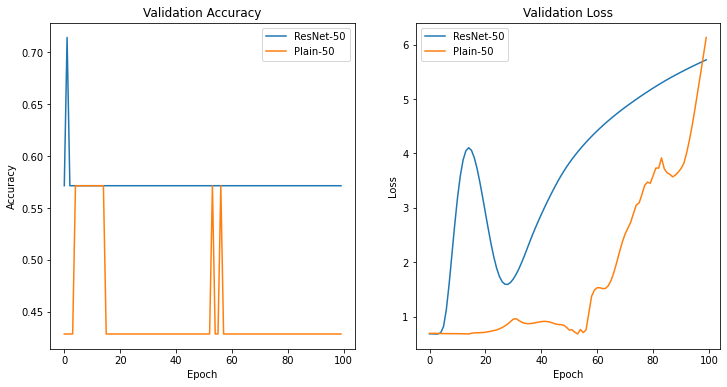

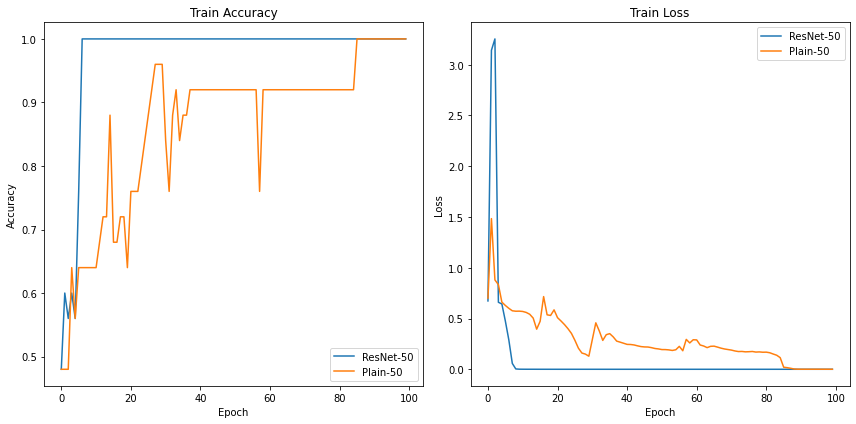

In [16]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

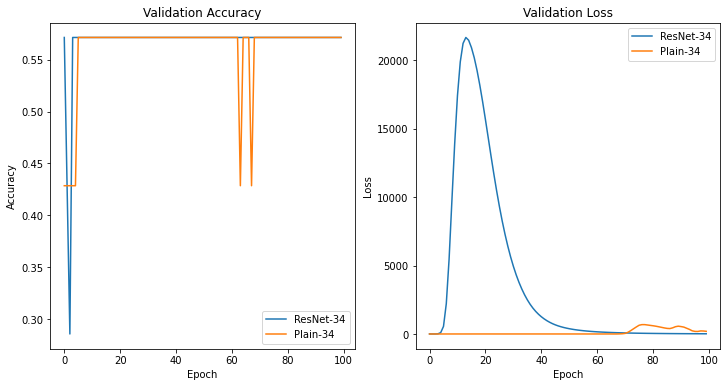

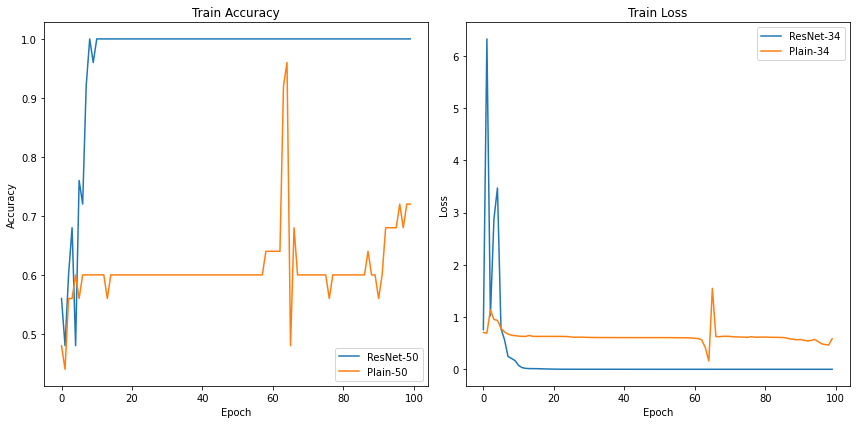

In [17]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

datasets load가 잘못된거 같다....

### Ablation Study
#### tf_flowers datasets

In [18]:
import urllib3
import tensorflow_datasets as tfds

urllib3.disable_warnings()

# Load the tf_flowers dataset
dataset_name = 'tf_flowers'
train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

# Preprocess the images and create batches
batch_size = 32
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
input_shape = (224, 224, 3)
num_classes = 5
epoch = 60

In [19]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plain(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 24s 218ms/step - loss: 1.6262 - accuracy: 0.4084 - val_loss: 101.6158 - val_accuracy: 0.2793
Epoch 2/60
92/92 [==============================] - 18s 195ms/step - loss: 1.2100 - accuracy: 0.5320 - val_loss: 1.9529 - val_accuracy: 0.4455
Epoch 3/60
92/92 [==============================] - 18s 194ms/step - loss: 1.1112 - accuracy: 0.5743 - val_loss: 1.2462 - val_accuracy: 0.5341
Epoch 4/60
92/92 [==============================] - 18s 193ms/step - loss: 1.0136 - accuracy: 0.6185 - val_loss: 1.0569 - val_accuracy: 0.6172
Epoch 5/60
92/92 [==============================] - 18s 194ms/step - loss: 0.9836 - accuracy: 0.6376 - val_loss: 1.7325 - val_accuracy: 0.5545
Epoch 6/60
92/92 [==============================] - 18s 195ms/step - loss: 0.9548 - accuracy: 0.6512 - val_loss: 2.0426 - val_accuracy: 0.4932
Epoch 7/60
92/92 [==============================] - 18s 195ms/step - loss: 0.8932 - accuracy: 0.6601 - val_loss: 1.6468 - val_accuracy: 0.57

Epoch 58/60
92/92 [==============================] - 18s 195ms/step - loss: 0.0419 - accuracy: 0.9850 - val_loss: 2.1390 - val_accuracy: 0.6526
Epoch 59/60
92/92 [==============================] - 18s 194ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 1.6677 - val_accuracy: 0.7030
Epoch 60/60
92/92 [==============================] - 18s 195ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 1.6284 - val_accuracy: 0.7221


In [22]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 41s 380ms/step - loss: 1.7931 - accuracy: 0.4077 - val_loss: 6.1813 - val_accuracy: 0.3624
Epoch 2/60
92/92 [==============================] - 33s 354ms/step - loss: 1.2224 - accuracy: 0.5463 - val_loss: 22.1133 - val_accuracy: 0.4264
Epoch 3/60
92/92 [==============================] - 32s 352ms/step - loss: 1.1474 - accuracy: 0.5824 - val_loss: 1.2251 - val_accuracy: 0.5354
Epoch 4/60
92/92 [==============================] - 33s 354ms/step - loss: 1.0947 - accuracy: 0.5862 - val_loss: 3.2784 - val_accuracy: 0.4973
Epoch 5/60
92/92 [==============================] - 33s 354ms/step - loss: 0.9766 - accuracy: 0.6335 - val_loss: 1.0430 - val_accuracy: 0.6362
Epoch 6/60
92/92 [==============================] - 33s 354ms/step - loss: 0.8747 - accuracy: 0.6676 - val_loss: 0.9088 - val_accuracy: 0.6444
Epoch 7/60
92/92 [==============================] - 33s 355ms/step - loss: 0.8271 - accuracy: 0.6870 - val_loss: 1.6303 - val_accuracy: 0.599

Epoch 58/60
92/92 [==============================] - 33s 356ms/step - loss: 1.8536e-04 - accuracy: 1.0000 - val_loss: 1.9171 - val_accuracy: 0.6907
Epoch 59/60
92/92 [==============================] - 33s 354ms/step - loss: 1.3964e-04 - accuracy: 1.0000 - val_loss: 1.9410 - val_accuracy: 0.6921
Epoch 60/60
92/92 [==============================] - 33s 355ms/step - loss: 1.1305e-04 - accuracy: 1.0000 - val_loss: 1.9621 - val_accuracy: 0.6948


In [23]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 20s 187ms/step - loss: 1.6149 - accuracy: 0.2834 - val_loss: 3971.8628 - val_accuracy: 0.2493
Epoch 2/60
92/92 [==============================] - 17s 182ms/step - loss: 1.5013 - accuracy: 0.3151 - val_loss: 2914.3008 - val_accuracy: 0.1826
Epoch 3/60
92/92 [==============================] - 17s 182ms/step - loss: 1.3909 - accuracy: 0.3825 - val_loss: 4.6052 - val_accuracy: 0.3243
Epoch 4/60
92/92 [==============================] - 17s 182ms/step - loss: 1.3966 - accuracy: 0.3747 - val_loss: 3.8197 - val_accuracy: 0.1826
Epoch 5/60
92/92 [==============================] - 17s 181ms/step - loss: 1.3783 - accuracy: 0.3699 - val_loss: 1.6343 - val_accuracy: 0.3542
Epoch 6/60
92/92 [==============================] - 17s 182ms/step - loss: 1.3446 - accuracy: 0.4012 - val_loss: 1.9759 - val_accuracy: 0.3106
Epoch 7/60
92/92 [==============================] - 17s 182ms/step - loss: 1.3050 - accuracy: 0.4475 - val_loss: 3.2776 - val_accuracy: 

Epoch 58/60
92/92 [==============================] - 17s 183ms/step - loss: 0.6037 - accuracy: 0.7881 - val_loss: 3.5748 - val_accuracy: 0.5027
Epoch 59/60
92/92 [==============================] - 17s 182ms/step - loss: 0.6089 - accuracy: 0.7864 - val_loss: 1.5682 - val_accuracy: 0.6403
Epoch 60/60
92/92 [==============================] - 17s 182ms/step - loss: 0.5895 - accuracy: 0.7817 - val_loss: 2.8070 - val_accuracy: 0.6308


In [24]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=epoch)

Epoch 1/60
92/92 [==============================] - 31s 298ms/step - loss: 1.6887 - accuracy: 0.2568 - val_loss: 1.9157 - val_accuracy: 0.1635
Epoch 2/60
92/92 [==============================] - 27s 292ms/step - loss: 1.5111 - accuracy: 0.2984 - val_loss: 1.9019 - val_accuracy: 0.1785
Epoch 3/60
92/92 [==============================] - 27s 289ms/step - loss: 1.4518 - accuracy: 0.3331 - val_loss: 2.1249 - val_accuracy: 0.1975
Epoch 4/60
92/92 [==============================] - 27s 289ms/step - loss: 1.4069 - accuracy: 0.3549 - val_loss: 1.4953 - val_accuracy: 0.3460
Epoch 5/60
92/92 [==============================] - 27s 291ms/step - loss: 1.3912 - accuracy: 0.3733 - val_loss: 1.5760 - val_accuracy: 0.4019
Epoch 6/60
92/92 [==============================] - 27s 291ms/step - loss: 1.3753 - accuracy: 0.3808 - val_loss: 3.2977 - val_accuracy: 0.3229
Epoch 7/60
92/92 [==============================] - 27s 291ms/step - loss: 1.3510 - accuracy: 0.3965 - val_loss: 1.5755 - val_accuracy: 0.4087

Epoch 58/60
92/92 [==============================] - 27s 291ms/step - loss: 0.5890 - accuracy: 0.7851 - val_loss: 1.3225 - val_accuracy: 0.6594
Epoch 59/60
92/92 [==============================] - 27s 291ms/step - loss: 0.6154 - accuracy: 0.7691 - val_loss: 1.4176 - val_accuracy: 0.6444
Epoch 60/60
92/92 [==============================] - 27s 291ms/step - loss: 0.5488 - accuracy: 0.7977 - val_loss: 1.3260 - val_accuracy: 0.6281


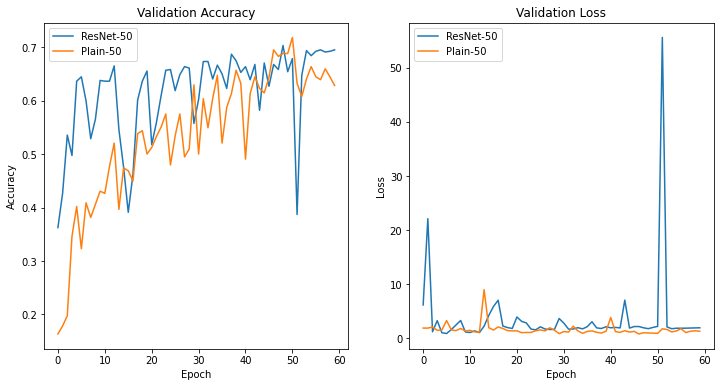

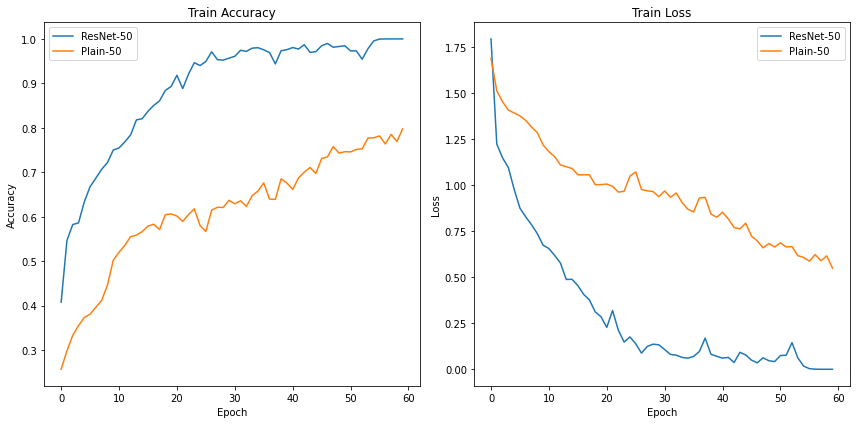

In [25]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

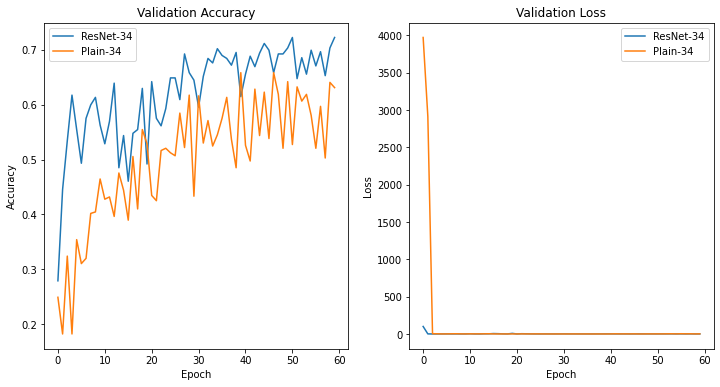

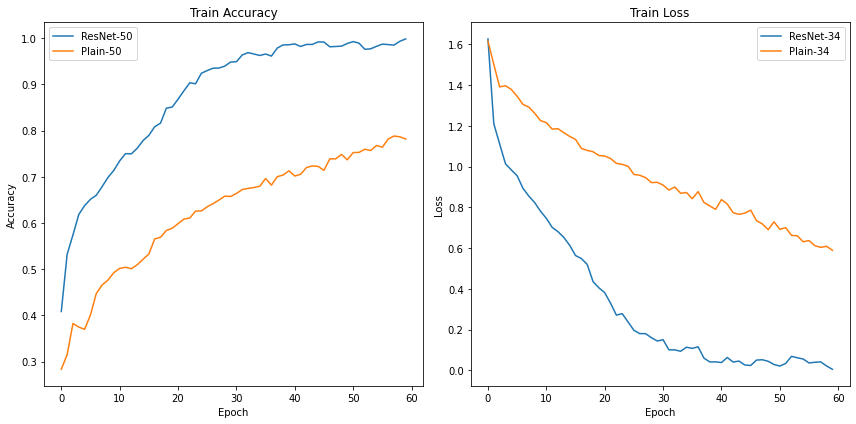

In [26]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()